#### The implementation of a sequential hybrid anomaly detection model using Isolation Forest and SVM begins by loading and cleaning your data. Then, select crucial features and split the data into training and testing sets. Standardize the features to ensure a uniform scale. First, fit an Isolation Forest to isolate potential anomalies quickly, followed by an SVM to refine anomaly detection with a precise classification boundary. Evaluate the model's performance using precision, recall, F1-score, and a confusion matrix to assess accuracy and sensitivity. This method combines the strengths of both models for robust anomaly detection.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import IsolationForest
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import LabelEncoder

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 350735 to 352413
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Global_active_power    50000 non-null  object 
 1   Global_reactive_power  50000 non-null  object 
 2   Voltage                50000 non-null  object 
 3   Global_intensity       50000 non-null  object 
 4   Sub_metering_1         50000 non-null  object 
 5   Sub_metering_2         50000 non-null  object 
 6   Sub_metering_3         49797 non-null  float64
dtypes: float64(1), object(6)
memory usage: 3.1+ MB
Precision: 0.969
Recall: 0.968
F1 Score: 0.969
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       903
           1       0.99      0.98      0.98      9057

    accuracy                           0.97      9960
   macro avg       0.90      0.92      0.91      9960
weighted avg       0.97      0.97      0.97    

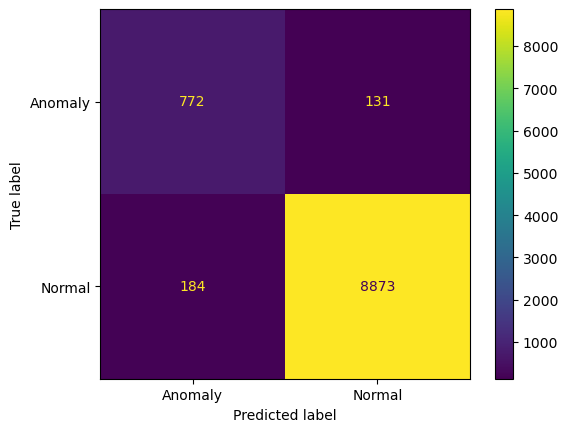

In [2]:

def hybrid_iso_svm():
    # Load the dataset
    data1 = pd.read_csv('pow_cons.csv')
    
    data = data1.sample(n=50000, random_state=5)
    
    data = data.drop(['Date','Time'], axis=1)
    data.info()
    
    data.dropna(axis=0, inplace=True)
    
    #convert all the values in the columns into numeric
    for column in data.columns:
        data[column] = pd.to_numeric(data[column], errors='coerce')
    
    X = data.drop('Global_active_power', axis=1)  # Assuming 'Global_active_power' is the target column
    y_cont = data['Global_active_power']

    # First, binarize `y` based on a chosen threshold.
    y = np.where(y_cont > 0.2, 1, 0)  # Define `threshold` based on the dataset

    # Select top k features; k might be adjusted based on the dataset
    selector = SelectKBest(f_classif, k=3)
    X_selected = selector.fit_transform(X, y)
    
    
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
        
    
    # Use Isolation Forest to identify normal data points
    iso_forest = IsolationForest(contamination=0.1, n_estimators=100, random_state=42)
    iso_forest.fit(X_train_scaled)
    iso_preds = iso_forest.predict(X_train_scaled)
    
    # Append Isolation Forest predictions as a new feature to the scaled data
    X_train_scaled_with_pred = np.hstack((X_train_scaled, iso_preds.reshape(-1, 1)))
    
    # Filter only normal data points as identified by Isolation Forest
    normal_indices = np.where(iso_preds == 1)[0]  # Assuming '1' is normal
    X_train_normal = X_train_scaled[normal_indices]
    y_train_normal = y_train[normal_indices]
    
    # Train SVM on the filtered normal data
    svm = SVC(kernel='rbf', gamma='auto', random_state=42)
    svm.fit(X_train_normal, y_train_normal)
    
    # Prepare test data by appending Isolation Forest predictions
    iso_preds_test = iso_forest.predict(X_test_scaled)
    X_test_scaled_with_pred = np.hstack((X_test_scaled, iso_preds_test.reshape(-1, 1)))
    
    # Predict using SVM on the test set
    svm_preds = svm.predict(X_test_scaled_with_pred[:, :-1])  # Exclude the appended Isolation Forest predictions
    
    # Evaluate the final outcome from SVM
    precision = precision_score(y_test, svm_preds, average='weighted', zero_division=0)
    recall = recall_score(y_test, svm_preds, average='weighted', zero_division=0)
    f1 = f1_score(y_test, svm_preds, average='weighted', zero_division=0)
    
    print(f'Precision: {precision:.3f}')
    print(f'Recall: {recall:.3f}')
    print(f'F1 Score: {f1:.3f}')
    
    
    print(classification_report(y_test, svm_preds))
    
    
    # Use a confusion matrix for visualization of the outcome
    
    cm = confusion_matrix(y_test, svm_preds, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Anomaly', 'Normal'])
    disp.plot()
    plt.show()

hybrid_iso_svm()